## SCRATCH
For plot improvement - delete once that code has been added into findTopics.py

In [145]:
import pandas as pd
import string
import numpy as np
import os
import pathlib
import re
from datetime import datetime
import pytz
from nltk.probability import FreqDist
from scipy import stats
from wordcloud import WordCloud
from gensim import corpora, models, similarities
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.corpus import stopwords
import sys
sys.path.append('/home/beeb/Insync/sei2112@columbia.edu/Google Drive/Columbia SusDev PhD/Research/My work/parler/code/lib')
import constants as c
import matplotlib.pyplot as plt
os.chdir(c.wd)
from statsmodels.stats.proportion import proportions_ztest
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import random

random.seed(c.SEED)
termsDict = {'qanon': ['qanon', 'wwg', 'wga', 'areqawake', 'qarmy', 'the[ ]{0,1}great[ ]{0,1}awakening',
        'the[ ]{0,1}storm', 'where[ ]{0,1}we[ ]{0,1}go[ ]{0,1}one[ ]{0,1}we[ ]{0,1}go[ ]{0,1}all',
        'trust[ ]{0,1}the[ ]{0,1}plan'],
            'health': ['vacc', 'covid', 'virus'],
            'china': ['china']}
def dataIn(path, keys, cutoffDate):
    # once working with full sample:
    dat = pd.DataFrame()
    plotDat = pd.DataFrame()
    problemPosts = pd.DataFrame()
    # iterate through all files, see which ones have mentions of at least
    # one of our topics of interest and keep only those
    errors = []
    for i in range(1, 3):#(c.NPOSTS + 1)):
        try:
            print('   Reading in dat {}'.format(i) + ' at ' + str(datetime.now()))
            newDat = pd.read_csv(path.format(str(i)),
                                 usecols = ['username', 'createdAtformatted', 'post', 'body'],
                                 parse_dates = ['createdAtformatted'])
            newDat = newDat[~pd.isnull(newDat.body)]
            
            # it should be the case that no users listed as joining after the cutoff date
            # posted anything before the cutoff date
            if not np.all(newDat.createdAtformatted[newDat.post == True] >= cutoffDate):
                newProblemPosts = newDat[(newDat.post == True)& (newDat.createdAtformatted < cutoffDate)]
                problemPosts = pd.concat([problemPosts, newProblemPosts])
                
            
            # get creation date from creation datetime
            newDat['createdAtDate'] = newDat['createdAtformatted'].dt.date
            newDat['createdAtYear'] = newDat['createdAtformatted'].dt.year
            newDat['createdAtWeek'] = newDat['createdAtformatted'].dt.isocalendar().week
            newPlotDat = pd.DataFrame(columns = ['post', 'createdAtDate', 'createdAtWeek', 'createdAtYear'])

            # create a flag for each keys being true
            for key in keys:
                newDat = createTermFlags(newDat, terms = termsDict[key], key = key)
                newPlotDat = newPlotDat.merge(prepPlotDat(newDat, key), 
                                              on = ['post', 'createdAtDate', 'createdAtWeek', 'createdAtYear'], 
                                              how = 'outer', 
                                              validate = '1:1')
        
            # create a flag for any key being true, keep only this data
            newDat['flag'] =  newDat[[i + 'Any' for i in keys]].max(axis = 1)
            newDat = newDat[newDat.flag == True]
            plotDat = pd.concat([plotDat, newPlotDat])
            dat = pd.concat([dat, newDat])
            print('success')
        except:
            errors.append(i)
    print(plotDat.head())
    plotDat = plotDat.reset_index().groupby(['post', 'createdAtDate', 'createdAtWeek', 'createdAtYear']).sum()
    plotDat.to_csv('plotDat.csv')
    dat.to_csv('dat.csv')
    pd.Series(errors).to_csv('errors.csv')
    return dat, plotDat
keys = termsDict.keys()
def createTermFlags(dat, terms, key):
    # iterate through terms, find which parleys contain them
    for term in terms:
        dat[term] = dat['body'].str.contains(term, regex = True, 
                                               flags = re.IGNORECASE)
    # create a flag for any of the terms mentioned
    dat[key + 'Any'] = dat[terms].max(axis = 1)

    return dat 

# by dat
def prepPlotDat(dat, key):
    plotDat = dat.groupby(['post', 'createdAtDate', 'createdAtWeek', 'createdAtYear']).agg({key + 'Any': ['count', 'sum']})[key + 'Any']
    plotDat.columns = [i + '_' + key for i in plotDat.columns]
    return plotDat.reset_index()

dat, plotDat = dataIn(c.samplePostsPath, keys, '2020-06-16')

   Reading in dat 1 at 2021-05-18 07:50:03.084100
success
   Reading in dat 2 at 2021-05-18 07:51:12.419039
    post createdAtDate  createdAtWeek  createdAtYear  count_qanon  sum_qanon  \
0  False    2019-12-23             52           2019            3          0   
1  False    2019-12-25             52           2019            1          0   
2  False    2019-12-26             52           2019            4          0   
3  False    2019-12-27             52           2019            2          0   
4  False    2019-12-29             52           2019            3          0   

   count_health  sum_health  count_china  sum_china  
0             3           0            3          0  
1             1           0            1          0  
2             4           0            4          0  
3             2           0            2          0  
4             3           0            3          0  


In [24]:
plotDat.head()

count_qanon  sum_qanon  count_health  \
post  createdAtDate createdAtWeek                                         
False 2019-12-21    51                       1          0             1   
      2019-12-22    51                       1          0             1   
      2019-12-23    52                       9          1             9   
      2019-12-24    52                       1          0             1   
      2019-12-25    52                       3          0             3   

                                   sum_health  count_china  sum_china  
post  createdAtDate createdAtWeek                                      
False 2019-12-21    51                      0            1          0  
      2019-12-22    51                      0            1          0  
      2019-12-23    52                      0            9          0  
      2019-12-24    52                      0            1          0  
      2019-12-25    52                      0            3          0

In [86]:
    dat = plotDatAgg.reset_index()
    key = 'qanon'
    # get number/average mentions over time
    #forPlotSum = dat.pivot('createdAtDate', 'post', 'sum' + '_' + key).fillna(0)
    dat['m'] = dat['sum'+ '_' + key]/dat['count'+ '_' + key]
    dat['timeCounter'] = pd.Series(dat.createdAtDate - cutoffDate).dt.days.astype(int)
    #forPlotMean = dat.pivot('createdAtDate', 'post', 'm').fillna(0)
    # make plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 7))
    sns.lineplot(#lowess = True,
                #scatter = True, 
                 x = 'timeCounter', y = 'm', hue = 'post',
                #scatter_kws = {'alpha': 0.1},
                data = dat[dat.timeCounter > 0])
    #sns.lineplot(ax = ax2,data = dat)
    ax1.legend(title = "User joined\nafter cutoff")
    ax2.legend(title = "User joined\nafter cutoff")
    #fig.savefig(outpath + 'fig.png')

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

In [112]:
cutoffDate = pd.Timestamp('2020-06-16')
def makePlot(key, plotDat, cutoffDate)
    plotDat['createdAtDate'] = pd.to_datetime(plotDat.createdAtDate)
    plotDat['timeCounter'] = pd.Series(plotDat.createdAtDate - cutoffDate).dt.days.astype(int)
    plotDat['weekCounter'] = np.floor(plotDat['timeCounter'] / 7)
    plotDatAgg = plotDat.groupby(['weekCounter', 'post'], as_index = False).agg({
        'createdAtDate':'count',
        'count_{}'.format(key): 'sum',
        'sum_{}'.format(key): 'sum'
    })
    plotDatAgg['weekMean'] = plotDatAgg['sum_{}'.format(key)] / plotDatAgg['count_{}'.format(key)]
    plotDatAgg['weekObs'] = plotDatAgg['sum_{}'.format(key)]
    plotDatAgg['weekSD'] = plotDatAgg['weekMean'] * (1 - plotDatAgg['weekMean']) / np.sqrt(plotDatAgg['weekObs'])
    plotDatAgg['weekCI'] = plotDatAgg['weekMSD'] * 1.96 * 2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 7))
    ax1.errorbar(x = plotDatAgg.weekCounter[plotDatAgg.post], 
                 y = plotDatAgg.weekMean[plotDatAgg.post], 
                 yerr = plotDatAgg.weekCI[plotDatAgg.post],
                color = 'orange', alpha = 0.7)
    ax1.errorbar(x = plotDatAgg.weekCounter[~plotDatAgg.post], 
                 y = plotDatAgg.weekMean[~plotDatAgg.post], 
                 yerr = plotDatAgg.weekCI[~plotDatAgg.post],
                color = 'blue', alpha = 0.3)
    sns.lineplot(ax = ax1,
                 ci = 'sd',
                 x = 'weekCounter', y = 'weekMean', hue = 'post',
                data = plotDatAgg)
    sns.lineplot(ax = ax2,
                 x = 'weekCounter', y = 'weekObs', hue = 'post',
                data = plotDatAgg)
    ax1.legend(title = "User joined\nafter cutoff")
    ax2.legend(title = "User joined\nafter cutoff")
    ax1.set_xlabel('Weeks relative to cutoff date')
    ax1.set_ylabel('Proportion of parleys which mention {}'.format(key))
    ax2.set_xlabel('Weeks relative to cutoff date')
    ax2.set_ylabel('Number of parleys which mention {}'.format(key))
    
    plt.savefig(outpath.format(key))

Text(0, 0.5, 'Number of parleys which mention qanon')

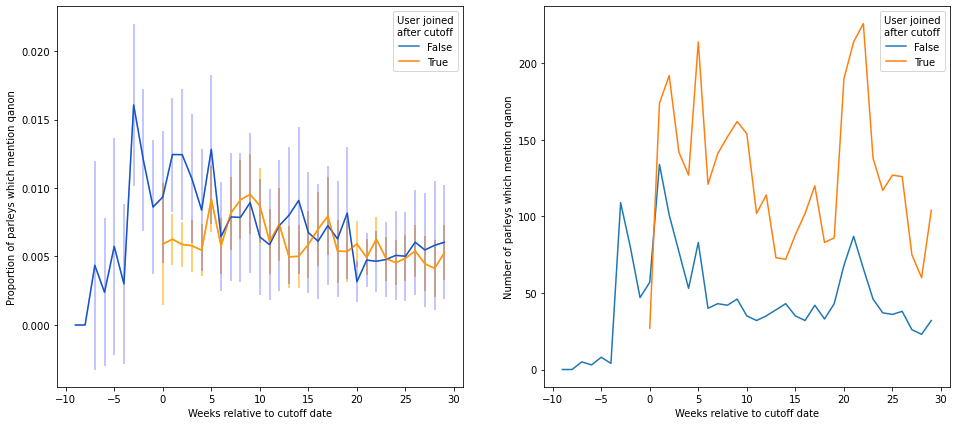

In [52]:
plotDat.groupby(['year'])

,post,createdAtDate,createdAtWeek,count_qanon,sum_qanon,count_health,sum_health,count_china,sum_china,createdAtYear,year
0,False,2019-12-21,51,1,0,1,0,1,0,2019,2019
1,False,2019-12-22,51,1,0,1,0,1,0,2019,2019
2,False,2019-12-23,52,9,1,9,0,9,0,2019,2019
3,False,2019-12-24,52,1,0,1,0,1,0,2019,2019
4,False,2019-12-25,52,3,0,3,0,3,0,2019,2019


In [54]:
plotDat.groupby(['createdAtYear', 'createdAtWeek']).agg({'count_qanon': 'sum', 'sum_qanon': 'sum', 'createdAtDate': 'count'})

count_qanon  sum_qanon  createdAtDate
createdAtYear createdAtWeek                                       
2019          1                       12          0              2
              24                       1          0              1
              51                       2          0              2
              52                      33          1              7
2020          1                       32          0              5
              2                       77          1              7
              3                       67          0              7
              4                       60          2              7
              5                       73          1              7
              6                      130          1              7
              7                      125          1              7
              8                      146          0              7
              9                      129          0              7
              10                     147          1              7
              11                     167          2              7
              12                     180          2              7
              13                     244          2              7
              14                    1407          2              7
              15                    1532          3              7
              16                    1003          0              7
              17                    1082          0              7
              18                    1195          5              7
              19                    1223          3              7
              20                    1372          8              7
              21                    1329          2              7
              22                    5969        105              7
              23                    6838         76              7
              24                    5628         49              7
              25                    9212         82             13
              26                   34118        265             14
              27                   42773        309             14
              28                   32391        227             14
              29                   27666        185             14
              30                   31892        297             14
              31                   27467        166             14
              32                   22971        175             14
              33                   22070        189             14
              34                   22354        217             14
              35                   22868        196             14
              36                   22567        128             14
              37                   20258        149             14
              38                   19626        122             14
              39                   19295        106             14
              40                   20054        129             14
              41                   19956        130             14
              42                   20297        154             14
              43                   20797        126             14
              44                   21103        125             14
              45                   43302        230             14
              46                   67446        321             14
              47                   51559        279             14
              48                   39782        205             14
              49                   33196        156             14
              50                   33228        163             14
              51                   30282        169             14
              52                   22833        102             14
              53                   10614         46              8
2021          1                    27704        152             14
         